<a href="https://www.kaggle.com/code/faressayah/toxic-tweet-classification-with-tensorflow?scriptVersionId=211564417" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📚 Natural Language Processing with Disaster Tweets 💬

🎯 Welcome to the toxic tweet classification notebook! This tutorial is hands-on and focused on how to fine-tune pre-trained models for specific use cases.

we will start by cleaning the dataset and then build a model to classify tweet. 

The base model we will use is [Twitter-roBERTa-base for Sentiment Analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?text=I+like+you.+I+love+you) 

In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel


print(tf.__version__)
print(transformers.__version__)

2.16.1
4.46.3


# 📋 Loading the Data

In [2]:
DATA_PATH = "../input/nlp-getting-started"

train = pd.read_csv(f"{DATA_PATH}/train.csv")
test = pd.read_csv(f"{DATA_PATH}/test.csv")
sample_sub = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 🔨 Preprocessing

In [5]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [6]:
SEQ_LEN = 256
BATCH_SIZE = 16
NUM_OF_SAMPLES = len(train)
MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
SPLIT_SIZE = 0.7

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
vocab_size = len(tokenizer.vocab)
print(f"[InFO]: Tokenizer for the model {MODEL_NAME} has {vocab_size} unique words")

max_sequence_length = tokenizer.model_max_length
print(f"[INFO]: Maximum sequence length the model {MODEL_NAME} is able to handle: {max_sequence_length}")

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=SEQ_LEN, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

y_train = train['target'].values
labels = np.zeros((NUM_OF_SAMPLES, y_train.max() + 1))
labels[np.arange(NUM_OF_SAMPLES), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=BATCH_SIZE, drop_remainder=True)

size = int((train_tokens['input_ids'].shape[0] // BATCH_SIZE) * SPLIT_SIZE)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

[InFO]: Tokenizer for the model cardiffnlp/twitter-roberta-base-sentiment-latest has 50265 unique words
[INFO]: Maximum sequence length the model cardiffnlp/twitter-roberta-base-sentiment-latest is able to handle: 1000000000000000019884624838656


# 🤖 Model Building

In [7]:
model = TFAutoModel.from_pretrained(MODEL_NAME)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

# Transformer
# embeddings = model.bert(input_ids, attention_mask=mask)[1]
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = embeddings[:, 0, :]
# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
# x = tf.keras.layers.Dropout(0.1)(x)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(x)

bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layers
# bert_model.layers[2].trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.BinaryAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=BATCH_SIZE
)

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/10


I0000 00:00:1733492542.208688      71 service.cc:145] XLA service 0x7b0f59d633b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733492542.208745      71 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733492542.378983      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


332/332 [==============================] - 241s 578ms/step - loss: 0.4489 - binary_accuracy: 0.8035 - val_loss: 0.3411 - val_binary_accuracy: 0.8632
Epoch 2/10
332/332 [==============================] - 183s 552ms/step - loss: 0.3706 - binary_accuracy: 0.8507 - val_loss: 0.3542 - val_binary_accuracy: 0.8615
Epoch 3/10
332/332 [==============================] - 183s 552ms/step - loss: 0.3193 - binary_accuracy: 0.8803 - val_loss: 0.2435 - val_binary_accuracy: 0.9082
Epoch 4/10
332/332 [==============================] - 183s 552ms/step - loss: 0.2801 - binary_accuracy: 0.8902 - val_loss: 0.1779 - val_binary_accuracy: 0.9401
Epoch 5/10
332/332 [==============================] - 183s 552ms/step - loss: 0.2374 - binary_accuracy: 0.9096 - val_loss: 0.1459 - val_binary_accuracy: 0.9493
Epoch 6/10
332/332 [==============================] - 183s 552ms/step - loss: 0.1968 - binary_accuracy: 0.9251 - val_loss: 0.1288 - val_binary_accuracy: 0.9537
Epoch 7/10
332/332 [==============================]

# 📊 Model Evaluation

In [8]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['binary_accuracy'], label='binary_accuracy')
    plt.plot(r.history['val_binary_accuracy'], label='val_binary_accuracy')
    plt.title('Accuracy score evolution during trainig')
    plt.legend();

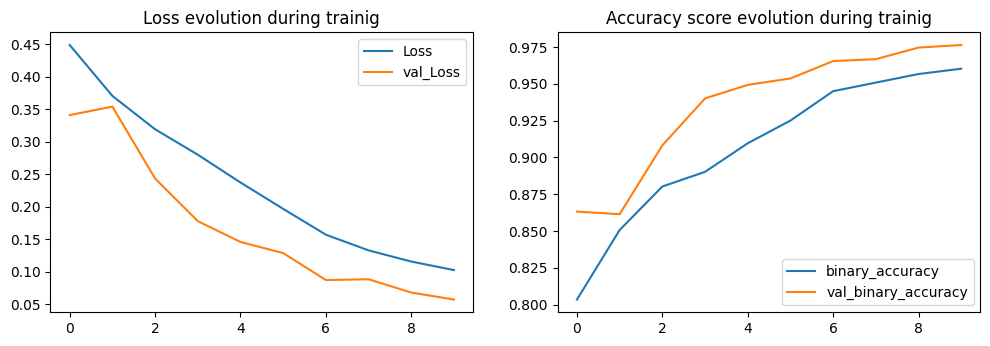

In [9]:
plot_learning_evolution(history)

In [10]:
bert_model.evaluate(val_ds)

143/143 [==============================] - 23s 158ms/step - loss: 0.0577 - binary_accuracy: 0.9786


[0.05767126753926277, 0.9785839319229126]

In [11]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length=256, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['target'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
#     probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'target'] = pred
    
test['target'] = test['target'].astype(int)

In [12]:
test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,Heard about earthquake is different cities sta...,1
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [13]:
test.target.value_counts()

target
0    1833
1    1430
Name: count, dtype: int64

# 5. Making submission

In [14]:
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(), 'target':test['target']})
sub.to_csv('submission.csv', index=False)

In [15]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
